# Gaussian Process Regression on a real-world data set
Part of CSME2, WS21/22, Exercise Session 13

Based on a notebook by Dominik Baumann from CSME2, WS20/21. Last edit 01/02/22.

In [14]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\stann\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['std', 'mean', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


We use data from the SARCOS dataset available at http://www.gaussianprocess.org/gpml/data/

In [9]:
training_data = scipy.io.loadmat('sarcos_inv.mat')
training_data = training_data['sarcos_inv']
x_train = training_data[:10000, 0:21]
y_train = training_data[:10000, 21]

test_data = scipy.io.loadmat('sarcos_inv_test.mat')
test_data = test_data['sarcos_inv_test']
x_test = test_data[:1000, 0:21]
y_test = test_data[:1000, 21]


noise_var = 1e-3

We plot some of the test data to get a feeling for what kind of data we are dealing with.

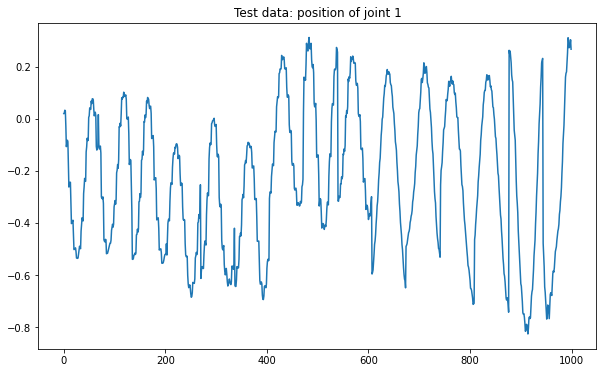

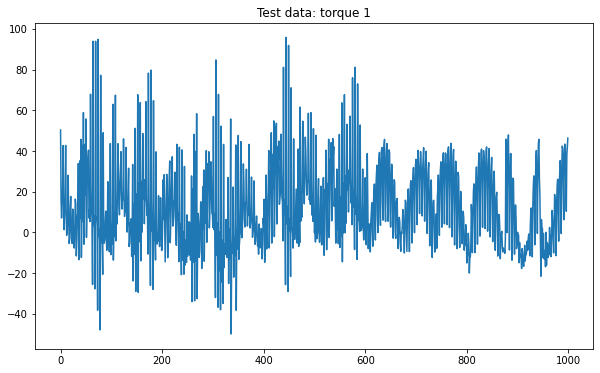

In [10]:
plt.title('Test data: position of joint 1')
plt.plot(x_test[:, 0])
plt.show()

plt.title('Test data: torque 1')
plt.plot(y_test)
plt.show()

To learn a model, we will again use the squared exponential kernel with $\sigma=1$ and $l=\sqrt{2}$.

In [11]:
def k_se(a, b):
    sqdist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2 * (a@b.T)
    return sigma*np.exp(-1/(2*l**2)*sqdist)

sigma = 1
l = np.sqrt(2)

As you have seen in the lecture, Gaussian processes scale cubically with the number of datapoints. This cost stems from the matrix inversion. Thus, for such a big dataset, we have to do this in a smarter way. Therefore, we here use the Cholesky decomposition to calculate the matrix inverse.

In [12]:
def get_posterior(k, x, xs, t):
    # Calculate mean
    L = np.linalg.cholesky(k(x, x) + noise_var*np.eye(x.shape[0]))
    a = np.linalg.solve(L.T, np.linalg.solve(L, t))
    mean = k(x, xs).T @ a
    
    # Calculate variance
    v = np.linalg.solve(L, k(x, xs))
    var = k(xs, xs) - v.T @ v
    
    return mean, var

We plot the posterior mean and uncertainty together with the test data and the mean-squared error. We can see that both posterior mean and test data behave similarly and also the mean-squared error is very low. Importantly, this is data that has *not* been used to train the Gaussian process. Thus, we conclude that we learned a model that approximates the dynamics well.

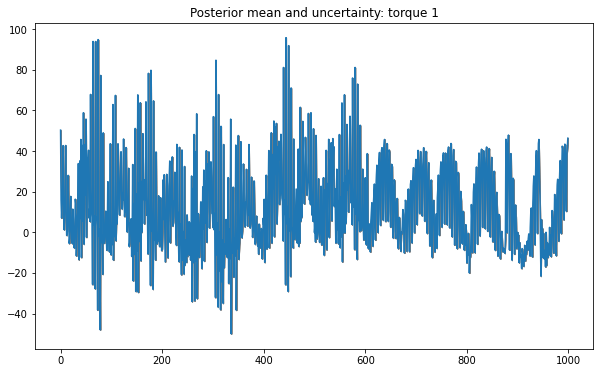

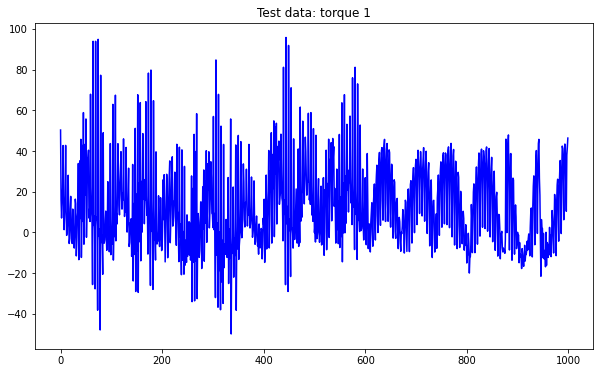

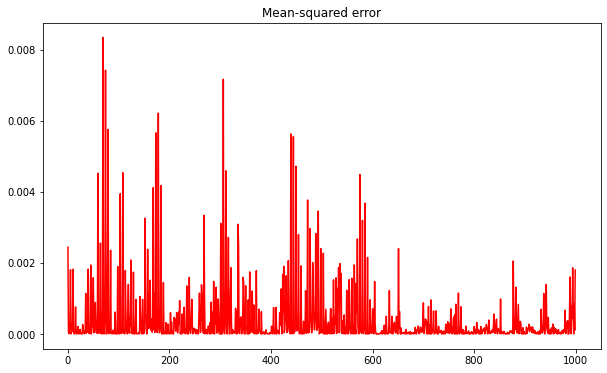

In [13]:
mean, var = get_posterior(k_se, x_train, x_test, y_train)
std = np.sqrt(np.diag(var))
    
plt.title('Posterior mean and uncertainty: torque 1')
plt.plot(mean)
plt.fill_between (np.linspace(0, mean.shape[0] - 1, mean.shape[0]), mean + 3*np.sqrt(np.diag(var)), mean - 3*np.sqrt(np.diag(var)), color='lightgray')
plt.fill_between (np.linspace(0, mean.shape[0] - 1, mean.shape[0]), mean + 2*np.sqrt(np.diag(var)), mean - 2*np.sqrt(np.diag(var)), color='darkgray')
plt.fill_between (np.linspace(0, mean.shape[0] - 1, mean.shape[0]), mean + 1*np.sqrt(np.diag(var)), mean - 1*np.sqrt(np.diag(var)), color='gray')
plt.show()

plt.title('Test data: torque 1')
plt.plot(y_test, 'b')
plt.show()

plt.title('Mean-squared error')
plt.plot((y_test-mean)**2, 'r')
plt.show()